# Análise de sentimento em rede de mídia social

O Twitter é uma plataforma de mídia social que produz centenas de milhões de mensagens por dia, com pessoas ao redor do mundo discutindo esportes, política, negócios e entretenimento. Mídias sociais são por natureza uma rede. As redes do Twitter se manifestam de várias maneiras, um dos tipos mais importantes de redes que aparecem no Twitter são as redes de retweets. É possível representá-las como grafos direcionados, com o usuário retweetando como a fonte e a pessoa retweetada como alvo. O presente trabalho tem o objetivo de fazer uma análise descritiva dos dados coletados. 

## Coleta de dados

Os dados para realização do presente trabalho tem origem de uma coleta de postagens do twitter via API utilizando o framework do python, o pacote usado para a coleta dos posts é o tweepy (https://tweepy.readthedocs.io/en/v3.5.0/), no qual foram usadas as funções “OAuthHandler” e “API” para a autenticação de usuário, que permite a coleta dos dados. Foram coletadas 23.989 postagens com a palavra-chave “Trump”. Para conseguir acesso a API do twitter para coleta de posts, é necessário seguir os passos conforme o site: https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens.html

In [ ]:
# Configurando a autenticação do pacote tweepy

# Carregando os pacotes necessários
from tweepy import OAuthHandler
from tweepy import API

# Autenticação da "consumer key"
consumer_key = "VGldO5N270dm4SBtiLSWi6UbM"
consumer_secret = "znpo5UgRmKqt9R1UuN2MonIw5TOkEVtvpuuZVSLvvwpRRhs9G0" 
auth = OAuthHandler(consumer_key, consumer_secret)

# Autenticação da "access key" 
access_token = "1087340053892919296-Ik0uNn63oStHrfQ8YUHoKAd5HanpUX"
access_token_secret = "VNzCDSqxD3nYdNUoLbIwPvJCOnBMZQwDBfmB8OufVFxZ1"
auth.set_access_token(access_token, access_token_secret)

# Configurando a API com a autenticação
api = API(auth)

In [ ]:
# Definindo as palavras ou hashtags que serão rastreadas
keywords_to_track = ['Trump']

In [ ]:
# Coletando posts do twitter através da API

from tweepy import Stream
from tweepy import StreamListener
import json
import time
import os
import sys

path = '/packages/Lib/site-packages'
sys.path.insert(0, os.getcwd() + path)

# Criando o SListener
class SListener(StreamListener):
    def __init__(self, api = None, fprefix = 'streamer'):
        self.api = api or API()
        self.counter = 0
        self.fprefix = fprefix
        self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')

    def on_data(self, data):
        if 'in_reply_to_status' in data:
            self.on_status(data)
        elif 'delete' in data:
            delete = json.loads(data)['delete']['status']
            if self.on_delete(delete['id'], delete['user_id']) is False:
                return False
        elif 'limit' in data:
            if self.on_limit(json.loads(data)['limit']['track']) is False:
                return False
        elif 'warning' in data:
            warning = json.loads(data)['warnings']
            print("WARNING: %s" % warning['message'])
            return

    def on_status(self, status):
        self.output.write(status)
        self.counter += 1
        if self.counter >= 20000 # define quantos posts serão coletados, no caso são 20.000 posts
            self.output.close()
            self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')
            self.counter = 0
        return

    def on_delete(self, status_id, user_id):
        print("Delete notice")
        return

    def on_limit(self, track):
        print("WARNING: Limitation notice received, tweets missed: %d" % track)
        return

    def on_error(self, status_code):
        print('Encountered error with status code:', status_code)
        return 

    def on_timeout(self):
        print("Timeout, sleeping for 60 seconds...")
        time.sleep(60)
        return 

# Criando uma instância para o SListener 
listen = SListener(api, 'Trump') # Inclui a palavra Trump no nome do arquivo

# Criando uma instância para Stream
stream = Stream(auth, listen)

# Coletando os posts do twitter!
print('A coleta dos posts começou! Obs: para pausar a coleta de posts do twitter através do stream, vá na aba "Files" do jupyter notebook, selecione o arquivo do jupyter notebook e clique em "Shutdown", isso é necessário para os códigos adiante funcionarem!')
stream.filter(track = keywords_to_track, languages=['en']) # o argumento "languages" define a língua dos posts que serão coletados no twitter

In [1]:
# Carregando os pacotes para a transformação do arquivo .json para data frame do pandas
import pandas as pd
import numpy as np
import json

# Carregando o arquivo .json com os posts do twitter
file = open('Trump_20190128-145725.json', 'r', encoding = 'utf-8') # no primeiro argumento inserir o arquivo, ex: 'file.json'
tweets_json = file.read().split("\n")

# Removendo linhas vazias
tweets_json = list(filter(len, tweets_json))

# Objeto que irá armazenar todos os posts do twitter 
tweets = []

# Iterando através de cada tweet
for tweet in tweets_json:
    try:
        tweet_obj = json.loads(tweet)
    
        # Armazenando o nome do usuário
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
    
        # Armazenando o nome do usuário que fez retweet e armazenando o texto do retweet
        if 'retweeted_status' in tweet_obj:
            tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
            tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
        
        # Armazenando citações
        if 'quoted_status' in tweet_obj:
            tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text'] 
            tweet_obj['quoted_status-user-screen_name'] = tweet_obj['quoted_status']['user']['screen_name']
    
        tweets.append(tweet_obj)
    except:
        pass

In [2]:
# Criando o data frame com pandas!
df_tweet = pd.DataFrame(tweets)
df_tweet = df_tweet.dropna(subset=['retweeted_status-user-screen_name', 'user-screen_name']).drop(df_tweet.index[23990])

## Análise de sentimento das postagens

A análise de sentimento é uma ferramenta de classificação de texto que analisa as palavras e retorna um sentimento positivo, negativo ou neutro. No presente trabalho será utilizado o modelo VADER (Valence Aware Dictionary for sEntiment Reasoning) de análise de sentimento, desenvolvido por Hutto, C. J. & Gilbert, E. E. (2014), a escala, ou score, desse método de análise de sentimento é de -1 a 1, sendo -1 o sentimento negativo, e 1 sentimento positivo.

In [3]:
# Carregando o pacote SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Criando uma instância para a função SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Gerando scores de sentimento dos retweetados
df_tweet['retweeted_status-text'] = df_tweet['retweeted_status-text'].astype(str) # isso é necessário para reparar possíveis erros de tipagem
target_sentiment = np.array(df_tweet['retweeted_status-text'].apply(sid.polarity_scores))

# Incluindo os scores de sentimento dos retweetados no data frame

# Proporção de sentimento negativo do post do retweetado
target_neg = []
for index, i in enumerate(target_sentiment):
    target_neg.append(target_sentiment[index].get('neg'))
    
# Proporção de sentimento neutro do post do retweetado
target_neu = []
for index, i in enumerate(target_sentiment):
    target_neu.append(target_sentiment[index].get('neu'))
    
# Proporção de sentimento positivo do post do retweetado
target_pos = []
for index, i in enumerate(target_sentiment):
    target_pos.append(target_sentiment[index].get('pos'))
      
# Score de sentimento do post do retweetado
target_compound = []
for index, i in enumerate(target_sentiment):
    target_compound.append(target_sentiment[index].get('compound'))
    
df_tweet['target_neg'] = target_neg
df_tweet['target_neu'] = target_neu
df_tweet['target_pos'] = target_pos
df_tweet['target_compound'] = target_compound

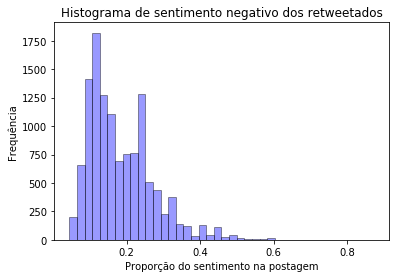

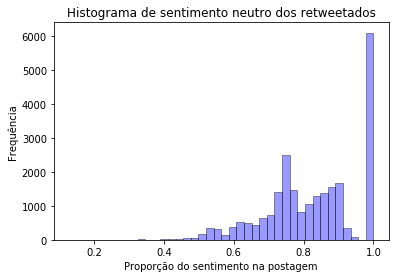

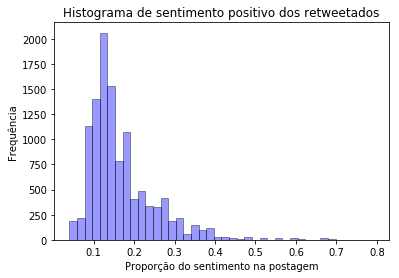

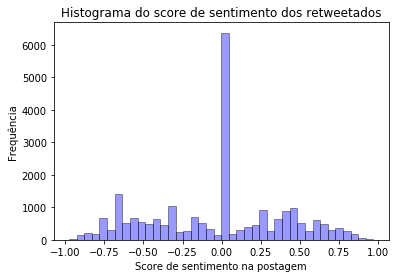

In [7]:
# Visualizando a frequência das proporções de sentimento dos retweetados

import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(df_tweet['target_neg'][(df_tweet['target_neg'] != 0.0)],
             hist=True, 
             kde=False,
             bins=int(200/5),
             color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histograma de sentimento negativo dos retweetados')
plt.xlabel('Proporção do sentimento na postagem')
plt.ylabel('Frequência')
plt.show()

sns.distplot(df_tweet['target_neu'][(df_tweet['target_neu'] != 0.0)],
             hist=True, 
             kde=False,
             bins=int(200/5),
             color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histograma de sentimento neutro dos retweetados')
plt.xlabel('Proporção do sentimento na postagem')
plt.ylabel('Frequência')
plt.show()
plt.show()

sns.distplot(df_tweet['target_pos'][(df_tweet['target_pos'] != 0.0)],
             hist=True, 
             kde=False,
             bins=int(200/5),
             color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histograma de sentimento positivo dos retweetados')
plt.xlabel('Proporção do sentimento na postagem')
plt.ylabel('Frequência')
plt.show()

sns.distplot(df_tweet['target_compound'],
             hist=True, 
             kde=False,
             bins=int(200/5),
             color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histograma do score de sentimento dos retweetados')
plt.xlabel('Score de sentimento na postagem')
plt.ylabel('Frequência')
plt.show()

In [8]:
# Gerando scores de sentimento dos retweets 
df_tweet['text'] = df_tweet['text'].astype(str) # isso é necessário para reparar possíveis erros de tipagem
source_sentiment = np.array(df_tweet['text'].apply(sid.polarity_scores))

# Incluindo os scores de sentimento dos retweets no data frame

# Proporção de sentimento negativo do post do retweet
source_neg = []
for index, i in enumerate(source_sentiment):
    source_neg.append(source_sentiment[index].get('neg'))
    
# Proporção de sentimento neutro do post do retweet
source_neu = []
for index, i in enumerate(source_sentiment):
    source_neu.append(source_sentiment[index].get('neu'))
    
# Proporção de sentimento positivo do post do retweet
source_pos = []
for index, i in enumerate(source_sentiment):
    source_pos.append(source_sentiment[index].get('pos'))
        
# Score de sentimento do post do retweet
source_compound = []
for index, i in enumerate(source_sentiment):
    source_compound.append(source_sentiment[index].get('compound'))
    
df_tweet['source_neg'] = source_neg
df_tweet['source_neu'] = source_neu
df_tweet['source_pos'] = source_pos
df_tweet['source_compound'] = source_compound

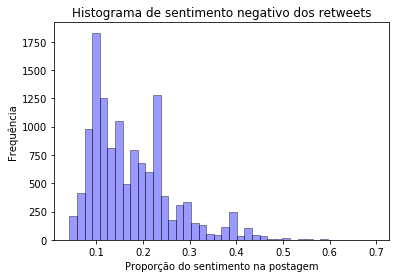

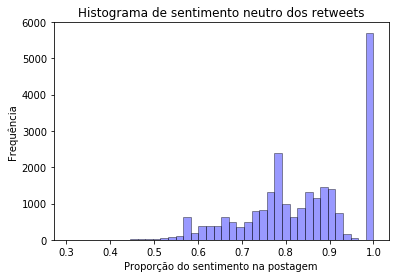

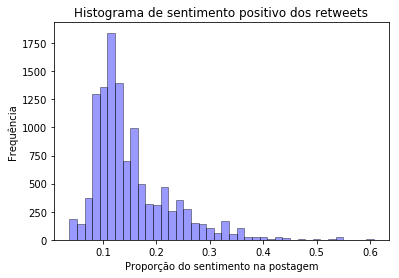

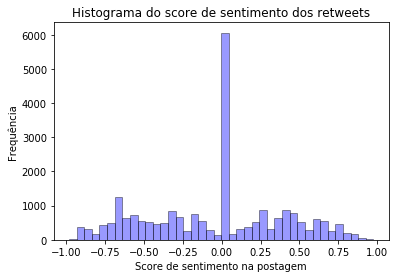

In [9]:
# Visualizando a frequência das proporções de sentimento dos retweets

import seaborn as sns

sns.distplot(df_tweet['source_neg'][(df_tweet['source_neg'] != 0.0)],
             hist=True, 
             kde=False,
             bins=int(200/5),
             color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histograma de sentimento negativo dos retweets')
plt.xlabel('Proporção do sentimento na postagem')
plt.ylabel('Frequência')
plt.show()

sns.distplot(df_tweet['source_neu'][(df_tweet['source_neu'] != 0.0)],
             hist=True, 
             kde=False,
             bins=int(200/5),
             color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histograma de sentimento neutro dos retweets')
plt.xlabel('Proporção do sentimento na postagem')
plt.ylabel('Frequência')
plt.show()
plt.show()

sns.distplot(df_tweet['source_pos'][(df_tweet['source_pos'] != 0.0)],
             hist=True, 
             kde=False,
             bins=int(200/5),
             color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histograma de sentimento positivo dos retweets')
plt.xlabel('Proporção do sentimento na postagem')
plt.ylabel('Frequência')
plt.show()

sns.distplot(df_tweet['source_compound'],
             hist=True, 
             kde=False,
             bins=int(200/5),
             color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Histograma do score de sentimento dos retweets')
plt.xlabel('Score de sentimento na postagem')
plt.ylabel('Frequência')
plt.show()

## Criando a rede de retweets

In [10]:
# Carregando o pacote networkx
import networkx as nx

# Criando a rede de retweets a partir da edgelist do data frame
G_rt = nx.from_pandas_edgelist(
    df_tweet,
    source = 'user-screen_name', 
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())

## Visualizando a rede de retweets

A visualização da rede de retweets permite inspecionar a estrutura da rede, entender se existe algum usuário que tenha influência desproporcional e se há diferentes esferas de conversação.

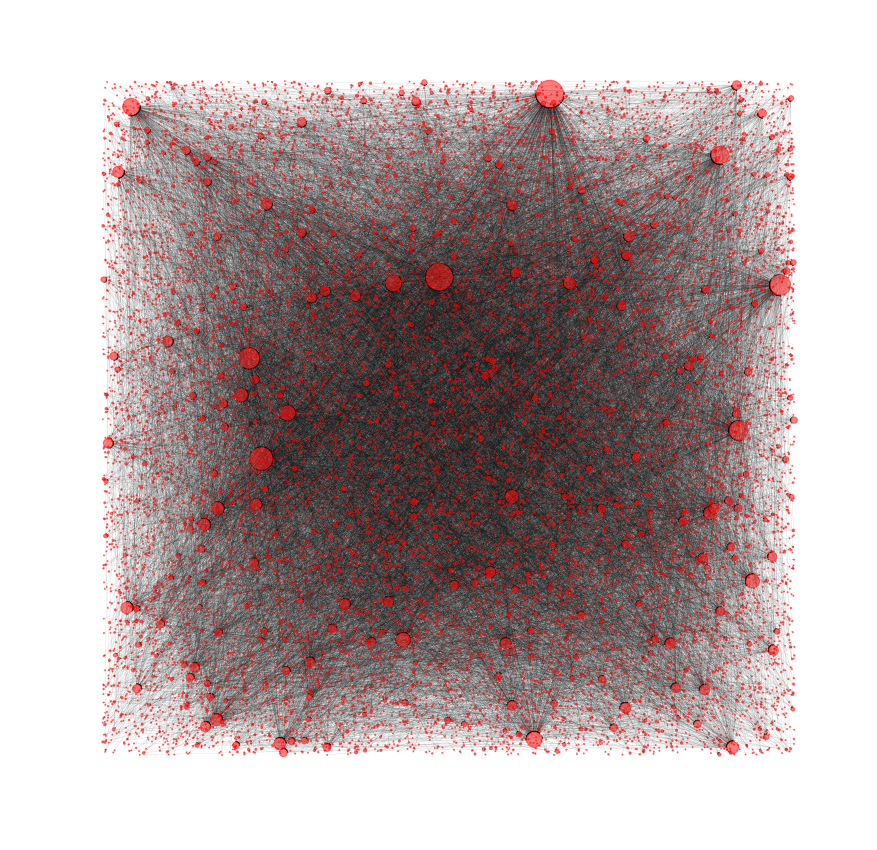

In [11]:
import matplotlib.pyplot as plt

# Ajusta o tamanho da imagem
plt.figure(figsize=(15, 15))

# Distribui uniformemente os nós no espaço 
pos = nx.random_layout(G_rt)

# Instância de tamanho dos nós
sizes = [x[1] for x in G_rt.degree()]

# Desenhando a rede de retweets!
nx.draw_networkx(G_rt,
                 pos,
                 with_labels = False, 
                 node_size = sizes,
                 width = 0.1, 
                 alpha = 0.5,
                 arrowsize = 2, 
                 linewidths = 1)

plt.axis('off')
plt.show()

## Centralidade in-degree

Conforme Newman (2010), o grau de um nó em um grafo é o número de arestas conectadas a ele, denotando o grau de vértice i por ki. Para um grafo não direcionado de n vértices, o grau pode ser escrito em termos da matriz adjacente como:

$$k_i=\sum_{j=1}^{n} {A}_{ij}$$

Graus de nós são mais complicados em redes direcionadas. Em uma rede direcionada, cada nó possui dois tipos de grau. O grau in-degree (de entrada) é o número de arestas de entrada conectadas a um nó e o out-degree (de saída) é o número de arestas de saída. Tendo em mente que a matriz de adjacência de uma rede direcionada possui o elemento Aij = 1, se houver uma borda de j para i, os graus in-degree e out-degree podem ser escritos:

$$k^{in}_i=\sum_{j=1}^{n} {A}_{ij}$$ 

$$k^{out}_i=\sum_{j=1}^{n} {A}_{ij}$$

Portanto a centralidade de grau é uma métrica de importância de um nó para uma rede. Para redes direcionadas como as do Twitter, é necessário ter o cuidado de distinguir entre centralidade de grau in-degree e out-degree, especialmente em redes de retweets. A centralidade in-degree para redes de retweets sinaliza usuários que estão recebendo muitos retweets.


In [12]:
# Centralidade in-degree para a rede de retweets 
rt_centrality = nx.in_degree_centrality(G_rt)

# Armazenando as centralidades em um data frame
column_names = ['screen_name', 'degree_centrality']
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)

# 10 primeiros nós com maior centralidade in-degree
print(rt.sort_values('degree_centrality', ascending = False).head(10))

         screen_name  degree_centrality
17      krassenstein           0.042949
238    charliekirk11           0.040482
84      kylegriffin1           0.028672
131  realDonaldTrump           0.024031
15      JohnJHarwood           0.023854
100      mitchellvii           0.020564
53        TeaPainUSA           0.017685
341        EdKrassen           0.016569
200    Mikel_Jollett           0.013925
7       tonyschwartz           0.013807


## Referências bibliográficas

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

M. E. J. Newman. Networks: An introduction. Oxford University Press, Oxford UK, 2010.